#Install/Import

In [1]:
!pip install --upgrade nfl_data_py
!pip install Pillow

import nfl_data_py as nfl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import urllib.request
import os
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
pd.set_option('display.max_columns', None)
desc = nfl.import_team_desc()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which i

#Epa/Play

In [11]:
weekly = nfl.import_weekly_data([2024])
seasonal = nfl.import_seasonal_data([2024], 'ALL')
ids = nfl.import_ids()

seasonal = pd.merge(seasonal, ids[['gsis_id', 'position', 'name', 'team']], left_on='player_id', right_on='gsis_id')
seasonal = seasonal[seasonal['attempts'] >= 90]
qbs = seasonal['player_id'].unique().tolist()
weekly = weekly[weekly['player_id'].isin(qbs)]
weekly = weekly[['player_id', 'player_name', 'week', 'passing_epa', 'rushing_epa', 'attempts', 'carries', 'sacks', 'recent_team']].fillna(0)

weekly = weekly.sort_values(by=['player_name', 'week'])
weekly['cumulative_passing_epa'] = weekly.groupby('player_name')['passing_epa'].cumsum()
weekly['cumulative_rushing_epa'] = weekly.groupby('player_name')['rushing_epa'].cumsum()
weekly['cumulative_attempts'] = weekly.groupby('player_name')['attempts'].cumsum()
weekly['cumulative_carries'] = weekly.groupby('player_name')['carries'].cumsum()
weekly['cumulative_sacks'] = weekly.groupby('player_name')['sacks'].cumsum()
weekly['epa_play'] = (weekly['cumulative_passing_epa'] + weekly['cumulative_rushing_epa']) / (weekly['cumulative_attempts'] + weekly['cumulative_carries'] + weekly['cumulative_sacks'])

all_weeks = pd.Series(range(1, weekly['week'].max() + 1))
players = weekly['player_name'].unique()
full_data = pd.DataFrame([(player, week) for player in players for week in all_weeks], columns=['player_name', 'week'])
weekly_full = pd.merge(full_data, weekly, on=['player_name', 'week'], how='left')
weekly_full = weekly_full.sort_values(by=['player_name', 'week'])
weekly_full = weekly_full.groupby('player_name').apply(lambda group: group.ffill())
weekly_full['attempts_per_week'] = weekly_full['cumulative_attempts'] / weekly_full['week']
weekly_full['meets_condition_up_to_week'] = weekly_full.groupby('player_name')['attempts_per_week'].transform(lambda x: (x >= 10).cummax())
weekly_full['meets_condition_this_week'] = weekly_full['attempts'] > 20
weekly_filtered = weekly_full[
    (weekly_full['attempts_per_week'] >= 10) |
    (weekly_full['meets_condition_up_to_week'] == True) |
    (weekly_full['meets_condition_this_week'] == True)
]

Downcasting floats.


<ipython-input-11-35bc19a48791>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  weekly_full = weekly_full.groupby('player_name').apply(lambda group: group.ffill())


In [12]:
graph_data = weekly_filtered[['player_id', 'player_name', 'recent_team', 'week', 'epa_play']]
graph_data['rank'] = graph_data.groupby('week')['epa_play'].rank(ascending=False, method='min')
desc = nfl.import_team_desc()
graph_data = pd.merge(graph_data, desc[['team_abbr', 'team_color', 'team_color2', 'team_logo_espn']], left_on='recent_team', right_on='team_abbr')
graph_data

<ipython-input-12-93a60ffbfbb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_data['rank'] = graph_data.groupby('week')['epa_play'].rank(ascending=False, method='min')


,player_id,player_name,recent_team,week,epa_play,rank,team_abbr,team_color,team_color2,team_logo_espn
0,00-0027973,A.Dalton,CAR,3,0.241714,5.0,CAR,#0085CA,#000000,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
1,00-0027973,A.Dalton,CAR,4,0.153321,8.0,CAR,#0085CA,#000000,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
2,00-0027973,A.Dalton,CAR,5,-0.000863,21.0,CAR,#0085CA,#000000,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
3,00-0027973,A.Dalton,CAR,6,-0.032075,27.0,CAR,#0085CA,#000000,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
4,00-0027973,A.Dalton,CAR,7,-0.120941,30.0,CAR,#0085CA,#000000,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
...,...,...,...,...,...,...,...,...,...,...
347,00-0036212,T.Tagovailoa,MIA,6,-0.023571,24.0,MIA,#008E97,#F58220,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
348,00-0036212,T.Tagovailoa,MIA,7,-0.023571,25.0,MIA,#008E97,#F58220,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
349,00-0036212,T.Tagovailoa,MIA,8,0.055085,20.0,MIA,#008E97,#F58220,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
350,00-0036212,T.Tagovailoa,MIA,9,0.183644,5.0,MIA,#008E97,#F58220,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png


#Graph - Season

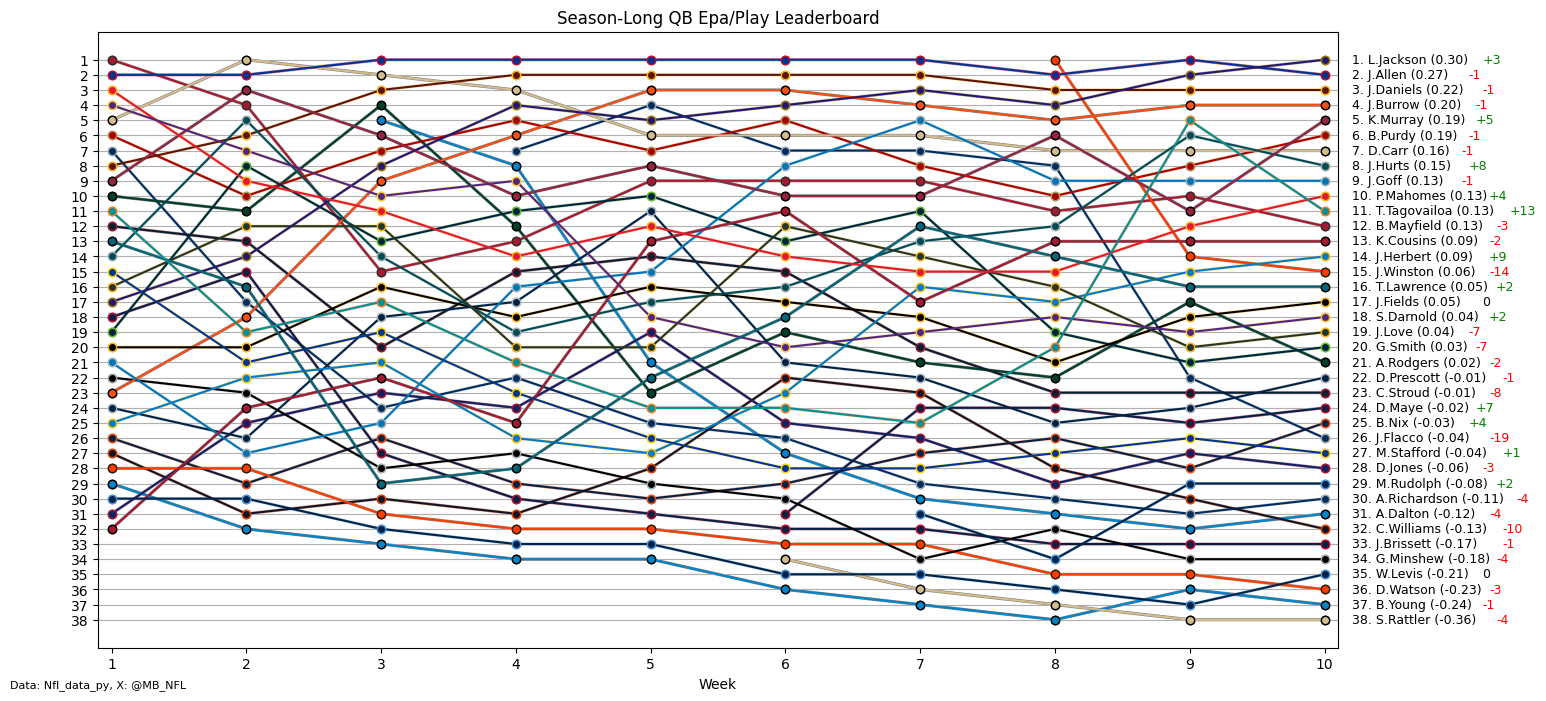

In [13]:
today = weekly['week'].max()

rank_change = {}

for player in graph_data['player_name'].unique():
    player_data = graph_data[graph_data['player_name'] == player]
    week_1_data = player_data[player_data['week'] == max(today - 4, 1)]
    if week_1_data.empty:
        earliest_week = player_data['week'].min()
        week_1_data = player_data[player_data['week'] == earliest_week]

    week_today_data = player_data[player_data['week'] == today]

    if not week_1_data.empty and not week_today_data.empty:
        rank_1 = week_1_data['rank'].iloc[0]
        rank_today = week_today_data['rank'].iloc[0]
        rank_change[player] = rank_1 - rank_today
    else:
        rank_change[player] = 0

fig, ax = plt.subplots(figsize=(16, 8))
for player in graph_data['player_name'].unique():
    player_data = graph_data[graph_data['player_name'] == player]

    team_color = player_data['team_color'].iloc[0]
    team_color2 = player_data['team_color2'].iloc[0]

    ax.plot(player_data['week'], player_data['rank'], marker='o', linestyle='-', color=team_color, markerfacecolor=team_color, markeredgecolor=team_color2)
    ax.plot(player_data['week'], player_data['rank'], color=team_color2, linewidth=2.25, alpha=0.5, zorder=1)
    ax.scatter(player_data['week'], player_data['rank'], color=team_color2)

    week_data = player_data[player_data['week'] == today]
    if not week_data.empty:
        rank = week_data['rank'].iloc[0]
        epa_play = week_data['epa_play'].iloc[0]

        rank_change_value = rank_change.get(player, 0)
        rank_change_label = f"{'+' if rank_change_value > 0 else ''}{int(rank_change_value)}"

        if rank_change_value > 0:
            rank_change_color = 'green'
        elif rank_change_value < 0:
            rank_change_color = 'red'
        else:
            rank_change_color = 'black'

        main_label = f"{rank:.0f}. {player} ({epa_play:.2f})"
        rank_change_part = f"{rank_change_label}"
        ax.text(today + 0.2, rank, main_label, va='center', ha='left', fontsize=9, color='black')
        ax.text(today + 0.2 + len(main_label) * 0.051, rank, rank_change_part, va='center', ha='left', fontsize=9, color=rank_change_color)


ax.set_xlabel('Week')
ax.set_title('Season-Long QB Epa/Play Leaderboard')
ax.text(0, -0.07, 'Data: Nfl_data_py, X: @MB_NFL', ha='center', va='bottom', fontsize=8, transform=ax.transAxes)
ax.set_yticks(graph_data['rank'].unique())
ax.set_xticks(graph_data['week'].unique())
ax.invert_yaxis()
plt.grid(True, axis='y')
ax.set_xlim(left=0.9, right=today + .1)
plt.show()

#Graph - Trailing 5

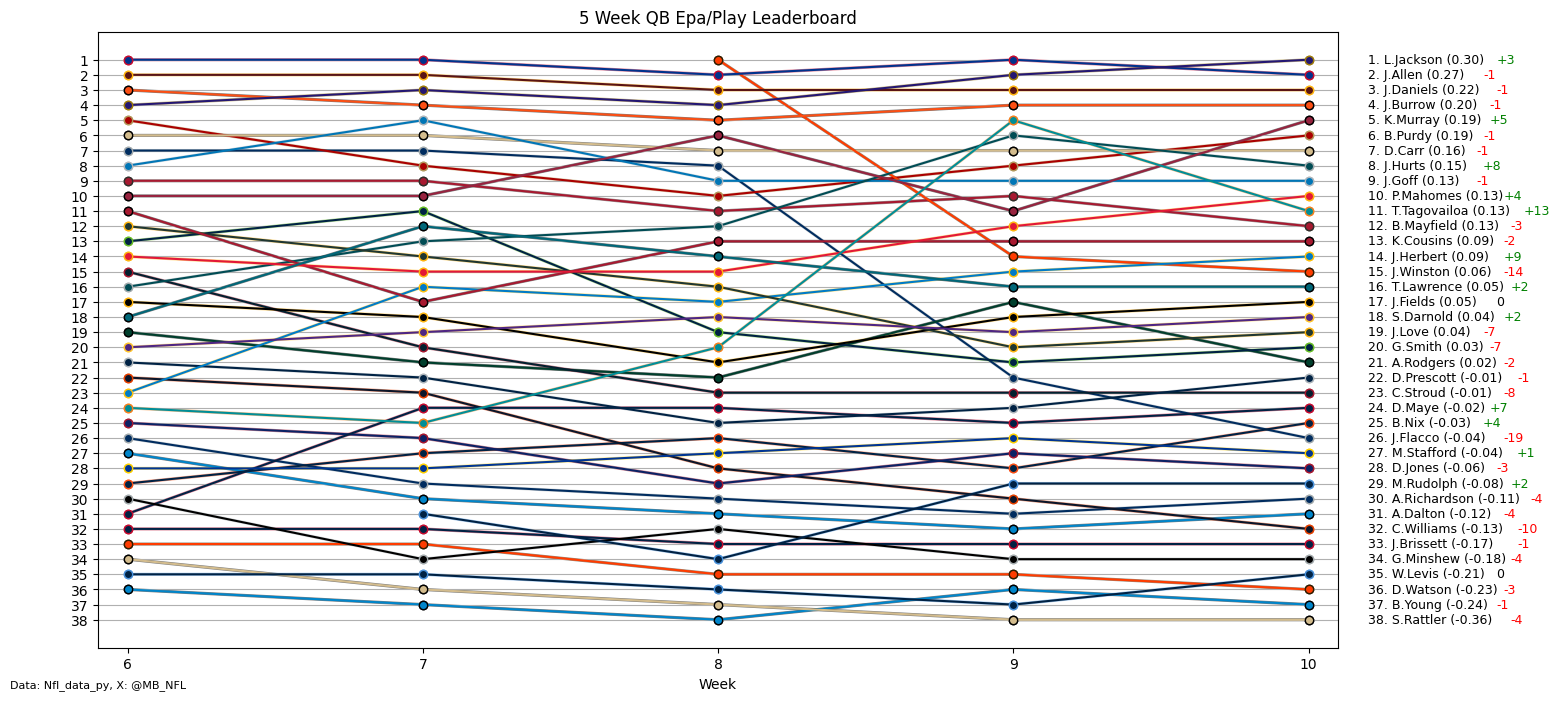

In [14]:
last_of_5_weeks = weekly['week'].max() ## CHANGE if you want to look at a different range of weeks other than the most recent 5
start_week = (last_of_5_weeks - 4)

rank_change = {}
for player in graph_data['player_name'].unique():
    start_week_ranks = graph_data[(graph_data['player_name'] == player) & (graph_data['week'] == start_week)]
    if start_week_ranks.empty:
        earliest_rank = graph_data[(graph_data['player_name'] == player) & (graph_data['rank'].notna())]
        if not earliest_rank.empty:
            start_week_ranks = earliest_rank.nsmallest(1, 'week')

    if not start_week_ranks.empty:
        start_week_rank = start_week_ranks['rank'].iloc[0]
        end_week_rank = graph_data[(graph_data['player_name'] == player) & (graph_data['week'] == last_of_5_weeks)]['rank'].iloc[0]
        rank_change[player] = end_week_rank - start_week_rank

filtered_data = graph_data[(graph_data['week'] >= start_week) & (graph_data['week'] <= last_of_5_weeks)]

fig, ax = plt.subplots(figsize=(16, 8))
for player in filtered_data['player_name'].unique():
    player_data = filtered_data[filtered_data['player_name'] == player]

    team_color = player_data['team_color'].iloc[0]
    team_color2 = player_data['team_color2'].iloc[0]

    ax.plot(player_data['week'], player_data['rank'], marker='o', linestyle='-', color=team_color, markerfacecolor=team_color, markeredgecolor=team_color2)
    ax.plot(player_data['week'], player_data['rank'], color=team_color2, linewidth=2.25, alpha=0.5, zorder=1)
    ax.scatter(player_data['week'], player_data['rank'], color=team_color2)

    rank_change_value = rank_change.get(player, 0)
    rank_change_value = -rank_change_value
    rank_change_label = f"{'+' if rank_change_value > 0 else ''}{int(rank_change_value)}"

    if rank_change_value > 0:
        rank_change_color = 'green'
    elif rank_change_value < 0:
        rank_change_color = 'red'
    else:
        rank_change_color = 'black'

    week_data = player_data[player_data['week'] == last_of_5_weeks]
    if not week_data.empty:
        rank = week_data['rank'].iloc[0]
        epa_play = week_data['epa_play'].iloc[0]
        main_label = f"{rank:.0f}. {player} ({epa_play:.2f})"
        rank_change_part = f"{rank_change_label}"
        ax.text(today + 0.2, rank, main_label, va='center', ha='left', fontsize=9, color='black')
        ax.text(today + 0.2 + len(main_label) * 0.023, rank, rank_change_part, va='center', ha='left', fontsize=9, color=rank_change_color)


ax.set_xlabel('Week')
ax.set_title('5 Week QB Epa/Play Leaderboard')
ax.text(0, -0.07, 'Data: Nfl_data_py, X: @MB_NFL', ha='center', va='bottom', fontsize=8, transform=ax.transAxes)
ax.set_yticks(filtered_data['rank'].unique())
ax.set_xticks(filtered_data['week'].unique())
ax.invert_yaxis()
plt.grid(True, axis='y')
ax.set_xlim(left=start_week - .1, right=today + .1)
plt.show()